<p align="center"><img width="50%" src="https://aimodelsharecontent.s3.amazonaws.com/aimodshare_banner.jpg" /></p>


---




<p align="center"><h1 align="center">Flower Image Classification Tutorial<br> 
</h1> 
<hr>
<h3 align="center">(Deploy model to an AI Model Share Model Playground REST API<br> and Web Dashboard in five easy steps...)</h3>
</p>
<p align="center"><img width="100%" src="https://aimodelsharecontent.s3.amazonaws.com/aimstutorialsteps.gif" /></p>



## **Credential Configuration**

In order to deploy an AI Model Share Model Playground, you will need a credentials text file. 

Generating your credentials file requires two sets of information: 
1. Your AI Model Share username and password (create them [HERE](https://www.modelshare.org/login)). 
2. Your AWS (Amazon Web Services) access keys (follow the tutorial [HERE](https://docs.aws.amazon.com/general/latest/gr/aws-sec-cred-types.html)). 

You only need to generate your credentials file once. After running the configure function below, save the outputted file for all your future Model Playground deployments and competition submissions. 

*Note: Handle your credentials file with the same level of security you handle your passwords. Do not share your file with anyone, send via email, or upload to Github.*

In [ ]:
#install aimodelshare library
! pip install aimodelshare --upgrade

In [ ]:
# Generate credentials file 
import aimodelshare as ai 
from aimodelshare.aws import configure_credentials 

configure_credentials()

## **Set up Environment**

Use your credentials file to set your credentials for all aimodelshare functions. 

In [ ]:
# Set credentials 
import aimodelshare as ai
from aimodelshare.aws import set_credentials

set_credentials(credential_file="credentials.txt", type="deploy_model")

AI Model Share login credentials set successfully.
AWS credentials set successfully.


In [ ]:
# Download flower image file (jpg) dataset
import aimodelshare as ai
ai.download_data("public.ecr.aws/y2e2a1d6/flower-competition-data-repository:latest")


Data downloaded successfully.


In [ ]:
# Extract filepaths to use to import and preprocess image files...
base_path = 'flower-competition-data/train_images'
categories = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Load file paths to fnames list object...
import os

fnames = []

for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

#print('number of images for each category:', [len(f) for f in fnames])
#print(fnames[0:4]) # Examples of file names...

## **(1) Preprocessor Function & Setup**

### **Write a Preprocessor Function**


> ###   Preprocessor functions are used to preprocess data into the precise data your model requires to generate predictions.  

*  *Preprocessor functions should always be named "preprocessor".*
*  *You can use any Python library in a preprocessor function, but all libraries should be imported inside your preprocessor function.*  
*  *For image prediction models users should minimally include function inputs for an image filepath and values to reshape the image height and width.*  


In [ ]:
# Here is a pre-designed preprocessor, but you could also build your own to prepare the data differently

def preprocessor(data, shape=(192, 192)):
        """
        This function preprocesses reads in images, resizes them to a fixed shape and
        min/max transforms them before converting feature values to float32 numeric values
        required by onnx files.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.


        # Resize all the images...
        X = np.array(img)
        X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels].
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform...

# Read in all images from filenames...
preprocessed_image_data = [preprocessor(x) for x in fnames[0] + fnames[1] + fnames[2] + fnames[3] + fnames[4]]

# tf.keras models require object to be an array rather than a list. (vstack converts above list to array object.)
import numpy as np
X = np.vstack(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model.

In [ ]:
X.shape

(2936, 192, 192, 3)

In [ ]:
# Create y training label data made up of correctly ordered labels from file folders...
from itertools import repeat

daisy = list(repeat("daisy", 507)) #i.e.: 507 filenames in daisy folder
dandelion = list(repeat("dandelion", 718))
roses = list(repeat("roses", 513))
sunflowers = list(repeat("sunflowers", 559))
tulips = list(repeat("tulips", 639))

# Combine into single list of y labels...
y_labels = daisy + dandelion + roses + sunflowers + tulips

# Check length, same as X above...
len(y_labels) 

# Need to one-hot encode for Keras. Let's use Pandas...
import pandas as pd
y = pd.get_dummies(y_labels)
display(y)

,daisy,dandelion,roses,sunflowers,tulips
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2931,0,0,0,0,1
2932,0,0,0,0,1
2933,0,0,0,0,1
2934,0,0,0,0,1


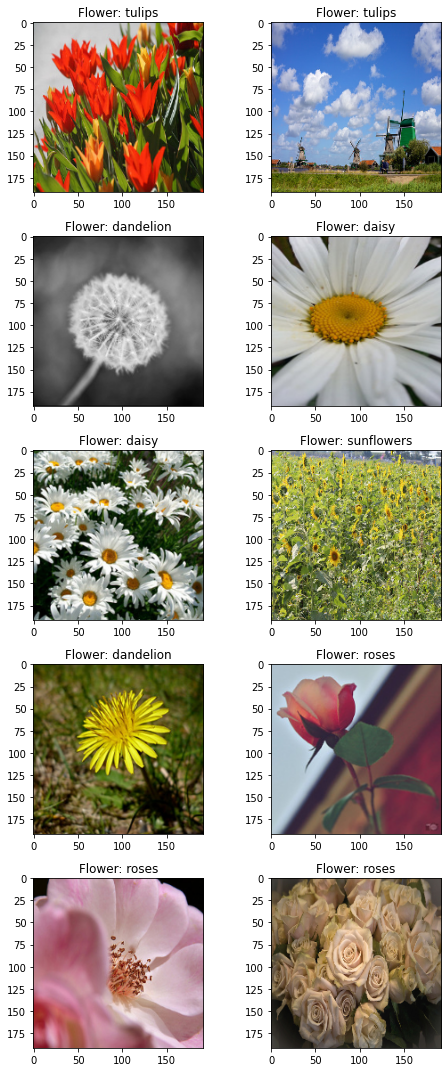

In [ ]:
# Visualize images...
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(5, 2)
fig.set_size_inches(7, 15)
for i in range(5):
    for j in range (2):
        l = np.random.randint(0, len(y_labels))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Flower: ' + y_labels[l])
        
plt.tight_layout()

In [ ]:
# train_test_split resized images...
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)
y_train 

,daisy,dandelion,roses,sunflowers,tulips
1046,0,1,0,0,0
28,1,0,0,0,0
2615,0,0,0,0,1
6,1,0,0,0,0
1807,0,0,0,1,0
...,...,...,...,...,...
61,1,0,0,0,0
429,1,0,0,0,0
1555,0,0,1,0,0
1077,0,1,0,0,0


## **(2) Train Model Using Keras (or Your Preferred ML Library)**

### Keras **Convolutional Neural Network**

In [ ]:
# Let's build a convnet model...
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
with tf.device('/device:GPU:0'): # "/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
                                 
        keras_model = Sequential()
        keras_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=[192, 192, 3]))
        keras_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
        keras_model.add(MaxPooling2D(pool_size=2))

        keras_model.add(Dropout(0.2))
        keras_model.add(Flatten())
        keras_model.add(Dense(16, activation='relu')) # One fully-connected layer of 16 neurons.
        keras_model.add(Dropout(0.2))

        keras_model.add(Dense(5, activation='softmax')) # Last fully-connected layer of 5 outputs (5 categories).

        # Compile model...
        keras_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        # Fitting the NN to the Training set...
        hist = keras_model.fit(X_train, y_train,
                          epochs=1, verbose=1, validation_data=(X_test, y_test))

74/74 [==============================] - 134s 2s/step - loss: 2.4151 - accuracy: 0.3254 - val_loss: 1.4145 - val_accuracy: 0.3027


## **(3) Save Preprocessor**
### Saves preprocessor function to "preprocessor.zip" file

In [ ]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
#  Now let's import and test the preprocessor function to see if it is working...

prep=ai.import_preprocessor("preprocessor.zip")

prep("flower-competition-data/train_images/daisy/10140303196_b88d3d6cec.jpg").shape

(1, 192, 192, 3)

## **(4) Save Keras Model to Onnx File Format**


In [ ]:
# Save tf.keras model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx
import keras

onnx_model = model_to_onnx(keras_model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
# Create one hot encoded data from list of y_train category labels
#   to allow ModelPlayground.deploy() to extract correct labels for predictions 

import pandas as pd
y_train = pd.get_dummies(y_train)

#ensure column names are correct in one hot encoded target for correct label extraction
list(y_train.columns)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Your live web-app will need example images (add some to a folder)

In [ ]:
# Create example data folder to provide on model playground page
#     for users to test prediction REST API 

import os 
import shutil

os.mkdir('example_data')
example_images = ["flower-competition-data/train_images/daisy/100080576_f52e8ee070_n.jpg", 
                  "flower-competition-data/train_images/dandelion/10200780773_c6051a7d71_n.jpg", 
                  "flower-competition-data/train_images/roses/10503217854_e66a804309.jpg", 
                  "flower-competition-data/train_images/sunflowers/1022552002_2b93faf9e7_n.jpg", 
                  "flower-competition-data/train_images/tulips/100930342_92e8746431_n.jpg"]
            
for image in example_images:
  shutil.copy(image, 'example_data')

## **(5) Create your Model Playground**

In [ ]:
#Set up arguments for Model Playground deployment
model_filepath="model.onnx"
preprocessor_filepath="preprocessor.zip"
exampledata_filepath = "example_data"

In [ ]:
from aimodelshare import ModelPlayground

#Instantiate ModelPlayground() Class

myplayground=ModelPlayground(model_type="image", classification=True, private=False)

# Create model playground (generates live rest api and web-app for your model/preprocessor)

myplayground.deploy(model_filepath, preprocessor_filepath, y_train, exampledata_filepath) 

# Note -- Change default Python libraries by setting custom_libararies='true' and entering library names
#Example: myplayground.deploy(model_filepath, preprocessor_filepath, example_data="data here", custom_libraries="true") 

We need some information about your model before we can build your REST API and interactive Model Playground.
   
Model Name (for AI Model Share Website):test
Model Description (Explain what your model does and 
 why end-users would find your model useful):test
Model Key Words (Search categories that describe your model, separated with commas):test
   
Creating your prediction API. (This process may take several minutes.)

[=====================================] Progress: 100% - Complete!                                            

Success! Your Model Playground was created in 67 seconds. 
 Playground Url: "https://4l5pqdofml.execute-api.us-east-1.amazonaws.com/prod/m"

You can now use your Model Playground.

Follow this link to explore your Model Playground's functionality
You can make predictions with the Dashboard and access example code from the Programmatic tab.
https://www.modelshare.org/detail/model:481


## **Use your new Model Playground!**

Follow the link in the output above to:
- Generate predictions with your interactive web dashboard
- Access example code in Python, R, and Curl

Or, follow the next tutorial to create a competition for your Model Playground and: 
- Access verified model performance metrics 
- Upload multiple models to a leaderboard 
- Easily compare model performance & structure 

## **Part 2: Create a Competition**

-------

After deploying your Model Playground, you can now create a competition. 

Creating a competition allows you to:
1. Verify the model performance metrics on aimodelshare.org
2. Submit models to a leaderboard
3. Grant access to other users to submit models to the leaderboard
4. Easily compare model performance and structure 

In [ ]:
# Create labels from one-hot encoded y_test
y_test_labels=list(y_test.idxmax(axis=1))

In [ ]:
# Create list of authorized participants for competition
# Note that participants should use the same email address when creating modelshare.org account

emaillist=["emailaddress1@email.com", "emailaddress2@email.com"]


In [ ]:
# Create Competition
myplayground.create_competition(data_directory='flower-competition-data', 
                                y_test = y_test_labels, email_list=emaillist) 

In [ ]:
#Instantiate Competition 
#--Note: If you start a new session, the first argument should be the Model Playground url in quotes. 
#--e.g.- mycompetition= ai.Competition("https://2121212.execute-api.us-east-1.amazonaws.com/prod/m")
#See Model Playground "Compete" tab for example model submission code.

mycompetition= ai.Competition(myplayground.playground_url)


In [ ]:
# Add, remove, or completely update authorized participants for competition later
emaillist=["emailaddress3@email.com"]

mycompetition.update_access_list(email_list=emaillist,update_type="Add")

Submit Models

In [ ]:
#Submit Model 1: 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=keras_model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 1

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:481


In [ ]:
# Create model 2 

with tf.device('/device:GPU:0'): # "/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      keras_model_2 = Sequential()
      keras_model_2.add(Dense(64,  input_shape=(192, 192, 3), activation='relu'))
      keras_model_2.add(Dense(64, activation='relu'))
      keras_model_2.add(Dense(64, activation='relu'))
      keras_model_2.add(Flatten())
      keras_model_2.add(Dense(5, activation='softmax')) 
                                                  
      # Compile model
      keras_model_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

      # Fitting the NN to the Training set
      keras_model_2.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_data=(X_test,y_test))
    

74/74 [==============================] - 190s 3s/step - loss: 6.6035 - accuracy: 0.4225 - val_loss: 1.5852 - val_accuracy: 0.4082


In [ ]:
# Save Model 2 to .onnx file

# Save tf.keras model to ONNX file
onnx_model2 = model_to_onnx(keras_model_2, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

# Save model to local .onnx file
with open("model_2.onnx", "wb") as f:
    f.write(onnx_model2.SerializeToString()) 

In [ ]:
# Submit Model 2

#-- Generate predicted y values (Model 2)
prediction_column_index=keras_model_2.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model_2.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip")

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 2

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:481


Get Leaderboard

In [ ]:
data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,conv2d_layers,dense_layers,dropout_layers,flatten_layers,maxpooling2d_layers,relu_act,softmax_act,loss,optimizer,model_config,memory_size,username,version
0,40.82%,35.06%,52.01%,40.43%,keras,False,True,Sequential,5,11805061,nan,4,nan,1,nan,3,1,str,RMSprop,"{'name': 'sequential_1', 'laye...",2283560,gstreett,2
1,41.50%,33.09%,44.41%,39.31%,keras,False,True,Sequential,14,7501213,6.000000,2,2.000000,1,3.000000,7,1,str,RMSprop,"{'name': 'sequential', 'layers...",2944400,gstreett,1


Compare Models

In [ ]:
# Compare two or more models (Experimental, Git-like Diffs for Model Architectures)
mycompetition.compare_models([1,2])

,Model_1_Layer,Model_1_Shape,Model_1_Params,Model_2_Layer,Model_2_Shape,Model_2_Params
0,Conv2D,"[None, 192, 192, 32]",416,Dense,"[None, 192, 192, 64]",256.0
1,Conv2D,"[None, 192, 192, 32]",4128,Dense,"[None, 192, 192, 64]",4160.0
2,MaxPooling2D,"[None, 96, 96, 32]",0,Dense,"[None, 192, 192, 64]",4160.0
3,Conv2D,"[None, 96, 96, 64]",8256,Flatten,"[None, 2359296]",0.0
4,Conv2D,"[None, 96, 96, 64]",16448,Dense,"[None, 5]",11796485.0
5,MaxPooling2D,"[None, 48, 48, 64]",0,NaN,NaN,NaN
6,Conv2D,"[None, 48, 48, 128]",32896,NaN,NaN,NaN
7,Conv2D,"[None, 48, 48, 128]",65664,NaN,NaN,NaN
8,MaxPooling2D,"[None, 24, 24, 128]",0,NaN,NaN,NaN
9,Dropout,"[None, 24, 24, 128]",0,NaN,NaN,NaN


#### Check structure of y test data 
(This helps users understand how to submit predicted values to leaderboard)

In [ ]:
mycompetition.inspect_y_test()

{'class_balance': {'daisy': 101,
  'dandelion': 144,
  'roses': 103,
  'sunflowers': 112,
  'tulips': 128},
 'class_labels': ['daisy', 'roses', 'sunflowers', 'dandelion', 'tulips'],
 'label_dtypes': {"<class 'str'>": 588},
 'y_length': 588,
 'ytest_example': ['roses', 'roses', 'roses', 'dandelion', 'roses']}

## **Part 3: Maintaining your Model Playground**

-------

Update Runtime model

*Use this function to 1) update the prediction API behind your Model Playground with a new model, chosen from the leaderboard and 2) verify the model performance metrics in your Model Playground*

In [ ]:
myplayground.update_runtime_model(model_version=2)

Runtime model & preprocessor for api: https://4l5pqdofml.execute-api.us-east-1.amazonaws.com/prod/m updated to model version 2.

Model metrics are now updated and verified for this model playground.


Delete Deployment 

*Use this function to delete the entire Model Playground, including the REST API, web dashboard, competition, and all submitted models*

In [ ]:
myplayground.delete_deployment()

Running this function will permanently delete all resources tied to this deployment, 
 including the eval lambda and all models submitted to the model competition.

To confirm, type 'permanently delete':permanently delete


'API deleted successfully.'